# RC Circuit

<!-- ![](/Users/mac/Development/projects/language-basics/julia/rc.png) -->
<img src="/Users/mac/Development/projects/language-basics/julia/rc.png" alt="" width="300" align="center">

$
V_R + V_C = V \\
V_R = I_R * R \\
I_C = C * \dot{V_C} \\
I_C = I_R
% \frac{dV_C}{dt}
$

$
\dot{V_C} = \frac{I_C}{C} = \frac{I_R}{C} = \frac{V_R/R}{C} = \frac{(V-V_C)/R}{C} =\frac{(V-V_C)}{RC}
$

### **Causal Modelling**
####  1. Component-Based Approach (Using Blocks)
**RC model similar to simulink** 

<img src="/Users/mac/Development/projects/language-basics/julia/rc_model.png" alt="" width="300" align="center">

In [1]:
using Pkg
Pkg.add([
    "ModelingToolkit",
    "ModelingToolkitStandardLibrary",
    "OrdinaryDiffEq"
])


   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [17]:
using ModelingToolkit
using ModelingToolkitStandardLibrary.Blocks: Integrator, Add, Gain, Step
using OrdinaryDiffEq


In [126]:
@parameters t R=10.0 C=0.1
@variables VC(t)
GAIN_VAL = 1.0 / (R * C) 

systems = @named begin 
    VC_int = Integrator(k=1.0, name=:VC_int) 
    adder = Add(k1=1, k2=-1) 
    c_gain = Gain(k=GAIN_VAL) 
    V = Step(start_time = 2, height = 1) # height = 1 means input V is 1
end;

causal_rc_eq = [
    connect(V.output, adder.input1)    
    connect(adder.output, c_gain.input)
    connect(c_gain.output, VC_int.input)
    connect(VC_int.output, adder.input2)   
    ];

In [127]:
# @named causal_rc = ODESystem(causal_rc_eq, t; systems);
@named causal_rc = ODESystem(causal_rc_eq, t, [VC], [R, C]; systems);

In [145]:

# Another approach

@component function RC_Causal(; name)
    @parameters t R=10.0 C=0.1
    @variables VC(t)
    GAIN_VAL = 1.0 / (R * C) 
    @named VC_int = Integrator(k=1.0, name = :VC_int) 
    @named adder = Add(k1=1, k2=-1) 
    @named c_gain = Gain(k=GAIN_VAL) 
    @named V = Step(start_time = 2, height = 1)
    
    causal_rc_eq = [
        connect(V.output, adder.input1)    
        connect(adder.output, c_gain.input)
        connect(c_gain.output, VC_int.input)
        connect(VC_int.output, adder.input2)   
    ];
    return ODESystem(causal_rc_eq, t, [VC], [R, C]; name, systems=[VC_int, adder, c_gain, V])
end

@named causal_rc = RC_Causal(name = :RC_Causal);


In [142]:
# model = compose(ODESystem(Equation[], t, [VC], [R, C]), system)
model = complete(causal_rc);

In [135]:
# sys = structural_simplify(causal_rc)
sys = structural_simplify(model);

In [136]:
prob = ODEProblem(sys, [VC => 0.0], (0, 10.0));


In [137]:
sol = solve(prob, Tsit5());

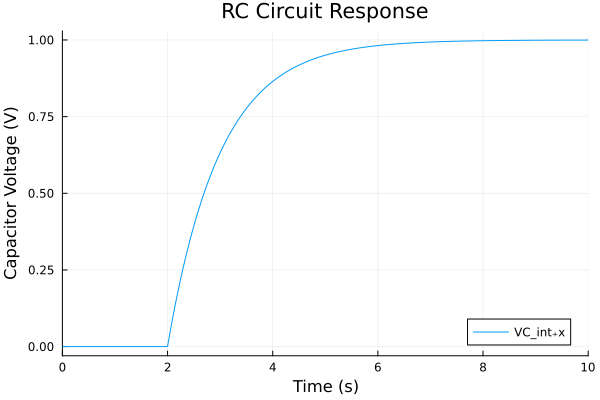

In [138]:
using Plots
plot(sol, title="RC Circuit Response", xlabel="Time (s)", ylabel="Capacitor Voltage (V)", legend=:bottomright)

####  2. Equation-Based Approach

In [79]:
using ModelingToolkit
using OrdinaryDiffEq

@parameters t R=10.0 C=0.1
@variables VC(t) V(t) = 1.0 # Define a constant input voltage for simplicity
D = Differential(t)

# The differential equation
eq = D(VC) ~ (1 / (R * C)) * (V - VC)

# Define the ODESystem
@named rc_model = ODESystem([eq], t, [VC], [R, C, V]) # [equations], time, [variables], [parameters]



Model rc_model:
Equations (1):
  1 standard: see equations(rc_model)
Unknowns (1): see unknowns(rc_model)
  VC(t)
Parameters (3): see parameters(rc_model)
  R [defaults to 10.0]
  C [defaults to 0.1]
  V(t) [defaults to 1.0]

In [80]:
model = complete(rc_model);
sys = structural_simplify(model);
prob = ODEProblem(sys, [VC => 0.0], (0, 10.0));
sol = solve(prob, Tsit5());

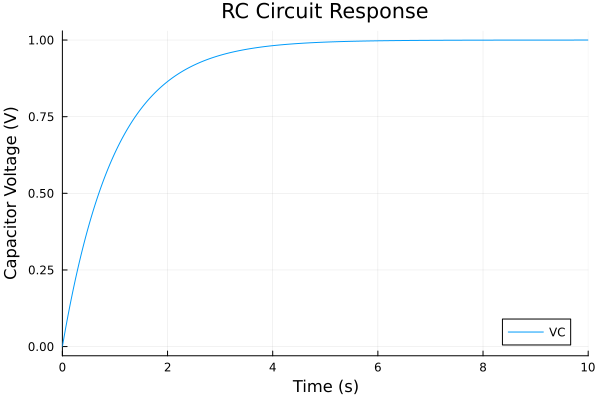

In [81]:
using Plots
plot(sol, title="RC Circuit Response", xlabel="Time (s)", ylabel="Capacitor Voltage (V)", legend=:bottomright)

### **Acausal Modelling**

In [ ]:
using ModelingToolkit
using ModelingToolkitStandardLibrary.Blocks: Integrator, Add, Gain, Step
using OrdinaryDiffEq

@parameters t R=10.0 C=0.1
@variables VC(t)

##### **Create connectors**

In [379]:
@connector Pin begin
    v(t), [description = "Potential at the pin [V]"]
    i(t), [connect = Flow, description = "Current flowing into the pin [A]"]

    # compose(ODESystem([], t, [v, i], []))
end

ModelingToolkit.Model{typeof(__Pin__), Dict{Symbol, Any}}(Main.__Pin__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :variables => Dict{Symbol, Dict{Symbol, Any}}(:v => Dict(:type => Real, :description => "Potential at the pin [V]"), :i => Dict(:type => Real, :description => "Current flowing into the pin [A]", :connection_type => :Flow)), :kwargs => Dict{Symbol, Dict}(:v => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :i => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => :t), true)

In [380]:
@component function PinPort(; name)
    @named p = Pin()
    @named n = Pin()

    sts = @variables v(t), i(t)

    eq = [
        v ~ p.v - n.v,
        i ~ p.i,
        p.i + n.i ~ 0
    ]

    compose(ODESystem(eq, t, sts, []; name), p, n)
end

PinPort (generic function with 1 method)

In [381]:

@component function Capacitor(; name, C = 1.0)
    @parameters t
    D = Differential(t)
    
    @named pinport = PinPort()
    @unpack v, i = pinport

    eq = [
        i ~ C * D(v)
    ]
    extend(ODESystem(eq, t, [], [C]; name), pinport)
end

Capacitor (generic function with 1 method)

In [382]:
@component function Inductor(; name, L = 1.0)
    @parameters t
    D = Differential(t)
    
    @named pinport = PinPort()
    @unpack v, i = pinport

    eq = [
        v ~ L * D(i)
    ]
    extend(ODESystem(eq, t, [], [L]; name), pinport)
end

Inductor (generic function with 1 method)

In [383]:
@component function Ground(; name)
    @named g = Pin()

    eq = [
        g.v ~ 0
    ]
    compose(ODESystem(eq, t, [], []; name), g)
end

Ground (generic function with 1 method)

In [384]:
@component function Voltage(; name, V = 1.0)
    @parameters t
    @variables v_in(t) [input = true, description = "External input signal [V]"]

    @named pinport = PinPort()
    @unpack v, i = pinport

    eq = [
        v ~ v_in
    ]
    extend(ODESystem(eq, t, [v_in], [V]; name), pinport)
end

Voltage (generic function with 1 method)

In [385]:
@component function Resistor(; name, R = 1.0)
    @parameters t
    
    @named pinport = PinPort()
    @unpack v, i = pinport

    eq = [
        v ~ i * R
    ]
    extend(ODESystem(eq, t, [], [R]; name), pinport)
end

Resistor (generic function with 1 method)

In [386]:

systems = @named begin 
    resistor = Resistor() 
    capacitor = Capacitor() 
    source = Voltage() 
    V = Step(start_time = 2, height = 1; name = :step) # height = 1 means input V is 1
    gnd = Ground()
end;



In [387]:
# V = Step(start_time = 2, height = 1; name = :step) # height = 1 means input V is 1

In [ ]:
causal_rc_eq = [
    connect(V.output.u, source.v_in) # Since V.output is a Causal port, the variable representing the signal is usually accessed as V.output.u
    # source.V_in ~ V.output.u
    # connect(source.p, resistor.p)
    # connect(resistor.n, capacitor.p)
    # connect(capacitor.n, source.n) 
    # connect(source.n, gnd.g)   

    # Connection between components (Standard Serial RC Circuit)
    connect(source.pinport.p, resistor.pinport.p)
    # connect(resistor.pinport.n, capacitor.pinport.p)
    
    # # Ground connections
    # connect(capacitor.pinport.n, source.pinport.n) # Ensures the loop is closed
    # connect(source.pinport.n, gnd.g) # Ground the common node
    ];

In [389]:
@named causal_rc = ODESystem(causal_rc_eq, t, [VC], [R, C]; systems);

### Acausal Modelling 2

In [271]:
using ModelingToolkit: t_nounits as t, D_nounits as D
using ModelingToolkitStandardLibrary.Blocks: Integrator, Add, Gain, Step, Constant
using OrdinaryDiffEq, Plots, ModelingToolkit
# using ModelingToolkitStandardLibrary.Electrical

# @parameters t R=10.0 C=0.1
# @variables VC(t)


**create connectors and components**

pin

In [272]:
@connector Pin begin
    v(t), [description = "Potential at the pin [V]"]
    i(t), [connect = Flow, description = "Current flowing into the pin [A]"]
end

ModelingToolkit.Model{typeof(__Pin__), Dict{Symbol, Any}}(Main.__Pin__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :variables => Dict{Symbol, Dict{Symbol, Any}}(:v => Dict(:type => Real, :description => "Potential at the pin [V]"), :i => Dict(:type => Real, :description => "Current flowing into the pin [A]", :connection_type => :Flow)), :kwargs => Dict{Symbol, Dict}(:v => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :i => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => :t), true)

ground

In [273]:
@mtkmodel Ground begin
    @components begin
        g = Pin()
    end

    @equations begin
        g.v ~ 0
    end
end

ModelingToolkit.Model{typeof(__Ground__), Dict{Symbol, Any}}(Main.__Ground__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :components => Any[Union{Expr, Symbol}[:g, :Pin]], :independent_variable => t, :equations => Any["g.v ~ 0"]), false)

oneport

In [274]:
@mtkmodel OnePort begin
    @components begin
        p = Pin()
        n = Pin()
    end

    @variables v(t), i(t)

    @equations begin
        v ~ p.v - n.v,
        i ~ p.i,
        # p.i + n.i ~ 0
        n.i ~ -i
    end
end

ModelingToolkit.Model{typeof(__OnePort__), Dict{Symbol, Any}}(Main.__OnePort__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :components => Any[Union{Expr, Symbol}[:p, :Pin], Union{Expr, Symbol}[:n, :Pin]], :variables => Dict{Symbol, Dict{Symbol, Any}}(:v => Dict(:type => Real), :i => Dict(:type => Real)), :kwargs => Dict{Symbol, Dict}(:v => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :i => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => :t, :equations => Any["v ~ ((p.v - n.v, i) ~ ((p.i, n.i) ~ -i))"]), false)

resistor

In [275]:
@mtkmodel Resistor begin 
    @extend OnePort() # Resistor inherits from OnePort
    @parameters begin
        R = 1.0
    end

    @equations begin
        v ~ i * R
    end
end

# OR 
@mtkmodel ResistorFull begin 
    @components begin
        p = Pin()
        n = Pin()
    end

    @variables v(t), i(t)
    @parameters begin
        R = 1.0
    end

    @equations begin
        v ~ p.v - n.v,
        i ~ p.i,
        0 ~ p.i + n.i
        v ~ i * R
    end
end

ModelingToolkit.Model{typeof(__ResistorFull__), Dict{Symbol, Any}}(Main.__ResistorFull__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :components => Any[Union{Expr, Symbol}[:p, :Pin], Union{Expr, Symbol}[:n, :Pin]], :variables => Dict{Symbol, Dict{Symbol, Any}}(:v => Dict(:type => Real), :i => Dict(:type => Real)), :kwargs => Dict{Symbol, Dict}(:R => Dict{Symbol, Any}(:value => 1.0, :type => Real), :v => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :i => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => :t, :parameters => Dict{Symbol, Dict{Symbol, Any}}(:R => Dict(:default => 1.0, :type => Real)), :equations => Any["v ~ ((p.v - n.v, i) ~ ((p.i, 0) ~ p.i + n.i))", "v ~ ((p.v - n.v, i) ~ ((p.i, 0) ~ p.i + n.i))", "v ~ i * R"]), false)

capacitor

In [276]:
@mtkmodel Capacitor begin 
    @extend OnePort() # Capacitor inherits from OnePort

    @parameters begin
        C = 1.0
    end

    @equations begin
        i ~ C * D(v)
    end
end

ModelingToolkit.Model{typeof(__Capacitor__), Dict{Symbol, Any}}(Main.__Capacitor__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :kwargs => Dict{Symbol, Dict}(:v => Dict(:value => ModelingToolkit.NoValue()), :i => Dict(:value => ModelingToolkit.NoValue()), :C => Dict{Symbol, Any}(:value => 1.0, :type => Real)), :independent_variable => t, :extend => Any[[:v, :i, :p, :n], Symbol("#mtkmodel__anonymous__OnePort"), :OnePort], :parameters => Dict{Symbol, Dict{Symbol, Any}}(:C => Dict(:default => 1.0, :type => Real)), :equations => Any["i ~ C * D(v)"]), false)

inductor

In [277]:
@mtkmodel Inductor begin
    @extend OnePort() # Inductor inherits from OnePort
    @parameters begin
        L = 1.0
    end

    @equations begin
        v ~ L * D(i)
    end
end

ModelingToolkit.Model{typeof(__Inductor__), Dict{Symbol, Any}}(Main.__Inductor__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :kwargs => Dict{Symbol, Dict}(:v => Dict(:value => ModelingToolkit.NoValue()), :L => Dict{Symbol, Any}(:value => 1.0, :type => Real), :i => Dict(:value => ModelingToolkit.NoValue())), :independent_variable => t, :extend => Any[[:v, :i, :p, :n], Symbol("#mtkmodel__anonymous__OnePort"), :OnePort], :parameters => Dict{Symbol, Dict{Symbol, Any}}(:L => Dict(:default => 1.0, :type => Real)), :equations => Any["v ~ L * D(i)"]), false)

voltage source

In [278]:
@mtkmodel ConstantVoltage begin
    @extend OnePort() # Capacitor inherits from OnePort
    @parameters begin
        V = 1.0
    end
    # @variables begin
    #     v_in(t)[input = true]
    # end
    # @variables v_in(t) [input = true]

    @equations begin
        # v ~ v_in #V
        v ~ V
    end
    # @extend ODESystem([], t, [v_in], [V]; name)
end

ModelingToolkit.Model{typeof(__ConstantVoltage__), Dict{Symbol, Any}}(Main.__ConstantVoltage__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :kwargs => Dict{Symbol, Dict}(:v => Dict(:value => ModelingToolkit.NoValue()), :V => Dict{Symbol, Any}(:value => 1.0, :type => Real), :i => Dict(:value => ModelingToolkit.NoValue())), :independent_variable => t, :extend => Any[[:v, :i, :p, :n], Symbol("#mtkmodel__anonymous__OnePort"), :OnePort], :parameters => Dict{Symbol, Dict{Symbol, Any}}(:V => Dict(:default => 1.0, :type => Real)), :equations => Any["v ~ V"]), false)

**create model**

In [279]:
@mtkmodel RCModel begin
    # @parameters begin
    #     R=10.0 
    #     C=0.1 
    #     V=1.0
    # end
    @variables begin
        # V(t) = Step(start_time = 2, height = 1; name = :step) # height = 1 means input V is 1
        V(t) = 1.0
    end

    @components begin
        resistor = Resistor() 
        capacitor = Capacitor() 
        source = ConstantVoltage()
        ground = Ground()
    end
    @equations begin
        # connect(V.output.u, source.v_in)
        connect(source.p, resistor.p)
        connect(resistor.n, capacitor.p)
        connect(capacitor.n, source.n, ground.g) 
        # connect(source.n, ground.g)   
    end
end

ModelingToolkit.Model{typeof(__RCModel__), Dict{Symbol, Any}}(Main.__RCModel__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :components => Any[Union{Expr, Symbol}[:resistor, :Resistor], Union{Expr, Symbol}[:capacitor, :Capacitor], Union{Expr, Symbol}[:source, :ConstantVoltage], Union{Expr, Symbol}[:ground, :Ground]], :variables => Dict{Symbol, Dict{Symbol, Any}}(:V => Dict(:default => 1.0, :type => Real)), :kwargs => Dict{Symbol, Dict}(:V => Dict{Symbol, Any}(:value => 1.0, :type => Real)), :independent_variable => :t, :equations => Any["connect(source.p, resistor.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(capacitor.n, source.n, ground.g)"]), false)

In [ ]:
@mtkbuild rc_model = RCModel()  #; resistor.R = 2.0

In [281]:
prob = ODEProblem(rc_model, [rc_model.capacitor.v => 0.0], (0, 10.0));
sol = solve(prob, Tsit5());

ModelingToolkit.SystemNotCompleteError: A completed system is required. Call `complete` or `mtkcompile` on the system before creating a `ODEProblem`.


In [282]:

plot(sol, title="RC Circuit Response", xlabel="Time (s)", ylabel="Capacitor Voltage (V)", legend=:bottomright)

UndefVarError: UndefVarError: `sol` not defined in `Main`
Suggestion: check for spelling errors or missing imports.